# Limpieza

In [69]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report



stopwords = set(stopwords.words('english'))

In [4]:
datos = pd.read_csv('dataset/final-train.csv')
datos.head()

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5


In [5]:
# Vemos la primera entrada de la columna 'text' y la columna 'summary'
print(datos['Text'][1])

This is a decent balsamic glaze/reducation.<br /><br />It has a faint yeasty taste that I don't care for...not so heavy to preclude using it again, but I have a different brand that I love love love, so this is just a back up.<br /><br />FYI try Blaze balsamic reduction/glaze.  It is superb.


In [6]:
print(datos['Summary'][0])

Can really notice when I am not drinking it


In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  426323 non-null  object
 1   Text     426340 non-null  object
 2   Score    426340 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.8+ MB


In [8]:
def limpiar_datos(dataframe):
    dataframe = dataframe.copy().dropna()
    dataframe['FullText'] = dataframe['Summary'] + ' ' + dataframe['Text']
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'<.*?>', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'\d+', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'[^\w\s]', ' ', regex=True).str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    dataframe = dataframe[['FullText','Score']]

    return dataframe

In [9]:
datos_limpio = limpiar_datos(datos)

In [10]:
print(datos_limpio['FullText'][1])

okay best decent balsamic glaze reducation faint yeasty taste care heavy preclude using different brand love love love back fyi try blaze balsamic reduction glaze superb


In [11]:
datos_limpio.head()

,FullText,Score
0,really notice drinking hormone problems past c...,5
1,okay best decent balsamic glaze reducation fai...,4
2,goo source fiber much source chocoate cookie m...,3
3,great gf staple yr old yr old eat gluten aweso...,5
4,coffee taste right without sweet n low drunk c...,5


## Entrenamiento

In [12]:
map_dict = {1: 0, 2:0, 3:1, 4:1, 5:1}

datos_limpio['Label'] = datos_limpio['Score'].map(map_dict)
datos_limpio.sample(10)

,FullText,Score,Label
310492,kettle foods spicy thai chips spicy thai chips...,2,0
368079,food revolution bought product ever since came...,5,1
176123,travis loves inconsistent size ordered number ...,4,1
205514,perfect small spaces portable bottle pretty kn...,5,1
396036,get better gjetost norwegian delicacy fiance b...,5,1
245233,sojos dog food received product quickly dogs l...,5,1
204577,priced many k cup piece take refill cup store ...,3,1
281765,wary duck treats china dog absolutely loved ye...,1,0
174359,british black tea like dark rich flavorful bri...,5,1
67368,stopped working well bad news think cat anxiou...,3,1


<Axes: ylabel='Frequency'>

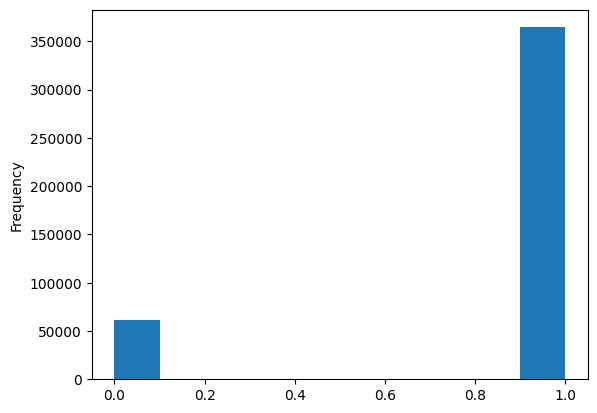

In [13]:
datos_limpio['Label'].plot(kind='hist')

In [14]:
datos_pos = datos_limpio[datos_limpio['Label'] == 1].sample(100000)
datos_neg = datos_limpio[datos_limpio['Label'] == 0]

In [15]:
datos_recortados = pd.concat([datos_neg, datos_pos], ignore_index=True, sort=False)

<Axes: ylabel='Frequency'>

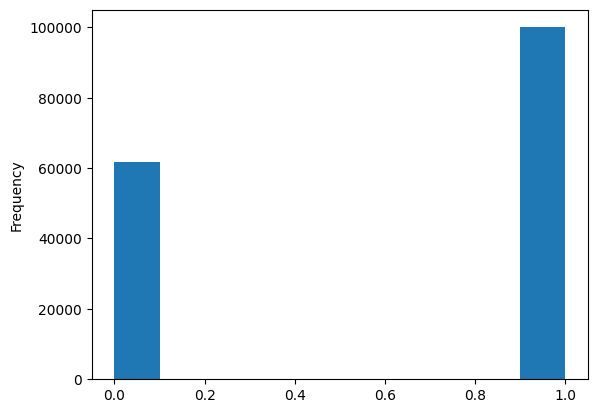

In [16]:
datos_recortados['Label'].plot(kind='hist')

In [43]:
len(datos_recortados['FullText'][0])

281

285.6158577292058


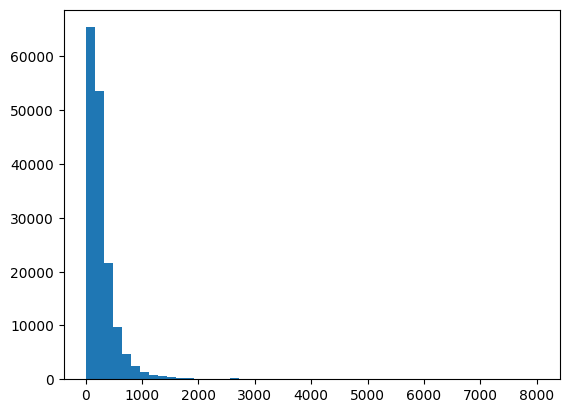

In [44]:
str_lengths = []
for row in datos_recortados['FullText']:
    str_lengths.append(len(row))

print(np.mean(str_lengths))
plt.hist(str_lengths, bins=50)
plt.show()

### Entrenando un modelo de machine learning (NB)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])

In [27]:
tfidf = TfidfVectorizer(max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
nb_classifier = MultinomialNB()

param_grid = {'alpha': np.arange(0, 1, 0.1),
              'fit_prior': [True, False]}

nb_classifier = GridSearchCV(nb_classifier, param_grid, cv=5, n_jobs=-1)

nb_classifier.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_prior': [True, False]})

In [30]:
best_alpha = nb_classifier.best_params_['alpha']
best_fit_prior = nb_classifier.best_params_['fit_prior']

print(f'Best alpha: {best_alpha}')
print(f'Best fit_prior: {best_fit_prior}')

Best alpha: 0.4
Best fit_prior: False


In [31]:
y_pred = nb_classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     18533
           1       0.90      0.89      0.89     30000

    accuracy                           0.87     48533
   macro avg       0.86      0.86      0.86     48533
weighted avg       0.87      0.87      0.87     48533



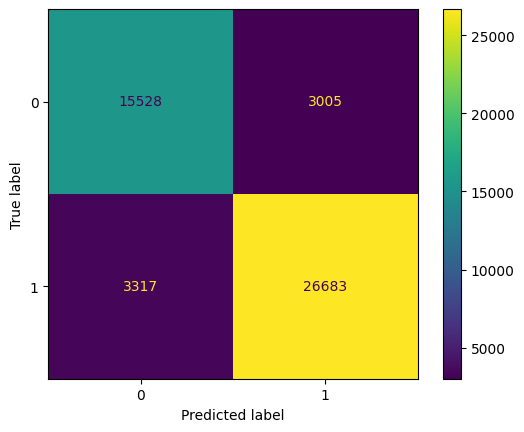

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()

### Entrenando un modelo tipo BERT

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
model_name = 'albert/albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
# Sample de los datos
sample_pos = datos_recortados[datos_recortados['Label'] == 1].sample(10000)
sample_neg = datos_recortados[datos_recortados['Label'] == 0].sample(10000)

sample = pd.concat([sample_pos, sample_neg], ignore_index=True, sort=False)

In [56]:
sample

,FullText,Score,Label
0,excellent green tea real tea drinker pleasure ...,5,1
1,dogs go crazy chicken arrived dogs smelling bo...,5,1
2,makes wonderful frozen drink enjoy chai tea ho...,5,1
3,outstanding rice blend really pleased ricesele...,5,1
4,delicious reasonably healthy sure really healt...,5,1
...,...,...,...
19995,complete ripoff product complete ripoff gave p...,1,0
19996,pecan pie larabar eating larabar bars years lo...,1,0
19997,fan care coffee first thing noticed opened sme...,2,0
19998,gummy bad taste fifties grew potato buds mom e...,1,0


In [57]:
X_train, X_test, y_train, y_test = train_test_split(sample['FullText'], sample['Label'], test_size=0.2, random_state=42, stratify=sample['Label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [58]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [68]:
# guardamos los encodings
torch.save(train_encodings, 'train_encodings.pt')
torch.save(val_encodings, 'val_encodings.pt')
torch.save(test_encodings, 'test_encodings.pt')

In [59]:
# cantidad de datos en cada conjunto
print(len(train_encodings['input_ids']), len(val_encodings['input_ids']), len(test_encodings['input_ids']))

12800 3200 4000


In [60]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(y_train)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(y_val)
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(y_test)
})

In [61]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    eval_strategy="epoch",    # Evaluar después de cada época
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.1,
    report_to="none"                # No reportar a Weights & Biases
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

In [62]:
trainer.train()

                                                 
100%|██████████| 200/200 [32:33<00:00,  9.77s/it]

{'eval_loss': 0.6950080394744873, 'eval_runtime': 84.0641, 'eval_samples_per_second': 38.066, 'eval_steps_per_second': 0.595, 'epoch': 1.0}
{'train_runtime': 1953.4952, 'train_samples_per_second': 6.552, 'train_steps_per_second': 0.102, 'train_loss': 0.7204383850097656, 'epoch': 1.0}


TrainOutput(global_step=200, training_loss=0.7204383850097656, metrics={'train_runtime': 1953.4952, 'train_samples_per_second': 6.552, 'train_steps_per_second': 0.102, 'total_flos': 76473925632000.0, 'train_loss': 0.7204383850097656, 'epoch': 1.0})

In [63]:
# Guardamos el modelo
model.save_pretrained('models/albert-base-v2')

In [64]:
eval_results = trainer.evaluate()
print(eval_results)

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

{'eval_loss': 0.6950080394744873, 'eval_runtime': 69.447, 'eval_samples_per_second': 46.078, 'eval_steps_per_second': 0.72, 'epoch': 1.0}


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


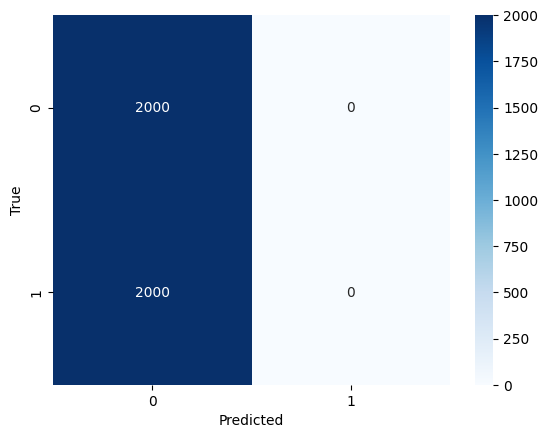

In [65]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2000
           1       0.00      0.00      0.00      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000



c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Entrenando otro modelo porque el Bert nomas no

In [70]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])

In [77]:
tfidf = TfidfVectorizer(max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [78]:
lr_classifier = LogisticRegression(max_iter=1000)

param_grid = {'C': np.arange(0, 1, 0.1),
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']}

lr_classifier = GridSearchCV(lr_classifier, param_grid, cv=5, n_jobs=-1)

lr_classifier.fit(X_train_tfidf, y_train)

c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\panda\miniconda3\envs\PLN\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [79]:
best_C = lr_classifier.best_params_['C']
best_penalty = lr_classifier.best_params_['penalty']
best_solver = lr_classifier.best_params_['solver']

print(f'Best C: {best_C}')
print(f'Best penalty: {best_penalty}')
print(f'Best solver: {best_solver}')

Best C: 0.9
Best penalty: l2
Best solver: liblinear


In [80]:
y_pred = lr_classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86     18533
           1       0.91      0.93      0.92     30000

    accuracy                           0.90     48533
   macro avg       0.89      0.89      0.89     48533
weighted avg       0.90      0.90      0.90     48533



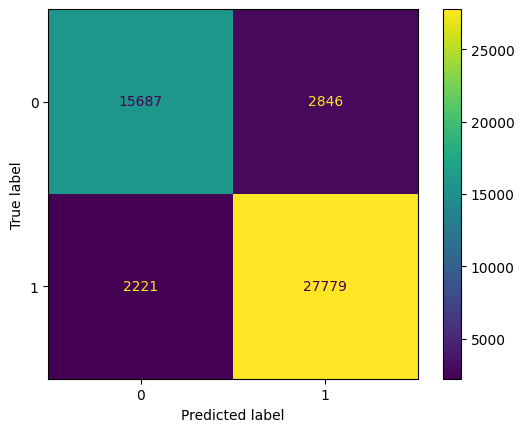

In [81]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
    